In [ ]:
%matplotlib tk

In [2]:
import numpy as np
import pylab as pl
import pandas as pd

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM

In [4]:
df =  pd.read_csv("test_v1.csv")
df.head()

,Data Op.,CumSum
0,01/08/2023,-30.43
1,01/08/2023,-42.93
2,01/08/2023,-46.93
3,03/08/2023,-3.76
4,04/08/2023,-8.76


In [ ]:
df.values

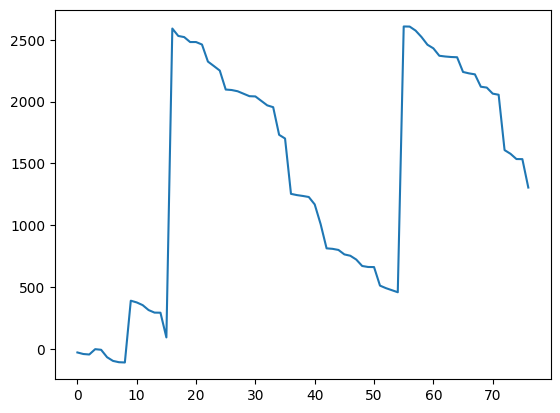

In [6]:
pl.plot(df.values[:,1])

In [7]:
A = df['CumSum'].values
Scaling = A.max()
A = A / Scaling

In [8]:
A.shape[0]

77

In [16]:
#Prepare RNN Dataset.
#Each data point (X) is linked to the previous data points of size=lookback
#The predicted value (Y) is the next point

lookback = 10

def create_rnn_dataset(data, lookback=1):

    data_x, data_y = [], []
    #for i in range(len(data) - lookback -1):
    for i in range(len(data[:,0]) - lookback -1):
        #All points from this point, looking backwards upto lookback
            a = data[i:(i+ lookback), :]
            data_x.append(a)
            #The next point
            data_y.append(data[i + lookback, :])
    return np.array(data_x), np.array(data_y)

#Create X and Y for training
train_req_x, train_req_y = create_rnn_dataset(A.reshape(A.shape[0],1) ,lookback)

#Reshape for use with LSTM
train_req_x = np.reshape(train_req_x,(train_req_x.shape[0],1, train_req_x.shape[1]))

print("Shapes of X, Y: ",train_req_x.shape, train_req_y.shape)

Shapes of X, Y:  (66, 1, 10) (66, 1)


In [17]:
#Create a Keras Model
ts_model=Sequential()
#Add LSTM
ts_model.add(LSTM(128, input_shape=(1,lookback)))
ts_model.add(Dense(1))

#Compile with Adam Optimizer. Optimize for minimum mean square error
ts_model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse"])

#Print model summary
ts_model.summary()

#Train the model
history = ts_model.fit(train_req_x,train_req_y, epochs=20, batch_size=1, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               71168     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 71297 (278.50 KB)
Trainable params: 71297 (278.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
66/66 [==============================] - 2s 3ms/step - loss: 0.1381 - mse: 0.1381
Epoch 2/20
66/66 [==============================] - 0s 3ms/step - loss: 0.0584 - mse: 0.0584
Epoch 3/20
66/66 [==============================] - 0s 3ms/step - loss: 0.0432 - mse: 0.0432
Epoch 4/20
66/66 [==============================] - 0s 4ms/step - loss: 0.0364 - mse: 0.0364
Epoch 5/20
66/66 [======================

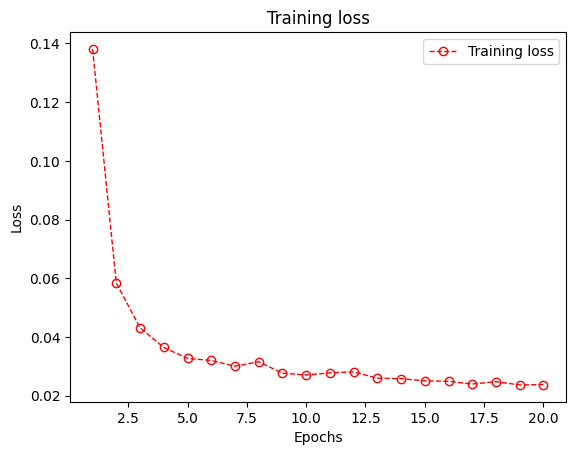

In [18]:
pl.figure(1)

loss = history.history['loss']
epochs = range(1, len(loss) + 1)
pl.plot(epochs, loss, "r--o", lw = 1, mfc = "none" ,label='Training loss')

pl.title('Training loss')
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()
pl.show()

In [19]:
predict_on_train = ts_model.predict(train_req_x)

3/3 [==============================] - 0s 4ms/step


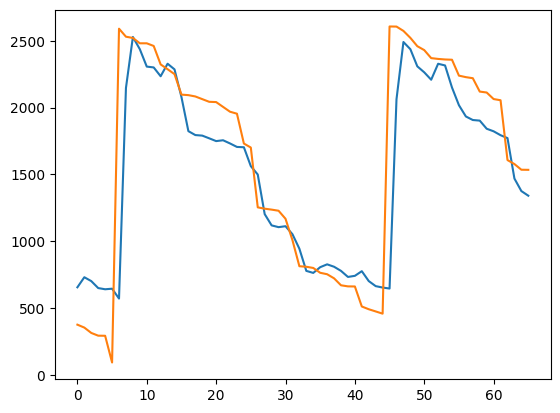

In [20]:
pl.figure(1)

pl.plot(predict_on_train*Scaling)
pl.plot(train_req_y*Scaling)

In [23]:
#predict in the future

#Predict for the next week
predict_for = 20

curr_input = train_req_x[-1,:,:].T

for i in range(predict_for):

    #Take the last lookback no. of samples as X
    this_input_ = curr_input[-lookback:,:]
    #Create the input
    this_input = this_input_.reshape((1,1,lookback))
    #Predict for the next point
    this_prediction = ts_model.predict(this_input)

    #Add the current prediction to the input
    curr_input = np.vstack([curr_input,this_prediction])

#Extract the last predict_for part of curr_input, which contains all the new predictions
predict_on_future=np.reshape(np.array(curr_input[-predict_for:,:]),(predict_for,1))

1/1 [==============================] - 0s 33ms/step


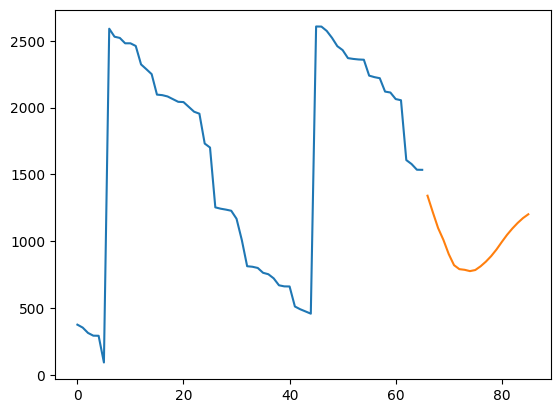

In [24]:
nt  = train_req_x.shape[0]
Np  = predict_on_future.shape[0]

pl.figure(3)

pl.plot(range(0,nt),train_req_y[:,0]*Scaling)
pl.plot(range(nt,nt+Np),predict_on_future[:,0]*Scaling)